# Aufbau der Notebooks [Philipp]

- Multivalue bei Notebooks angucken
- Wie installiere ich den "scheiß"
- Widgets: https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html


In [ ]:
# Importing libraries
from enum import Enum
import ipywidgets as widgets
from pandas import read_csv
import os
import numpy as np
import time

In [ ]:
# Setting up the global variables

PATH_RAW_DATA = "./data/raw/"
PATH_FEATURE_DATA = "./data/"
PATH_EXPLORATION_DATA = "./exploration/"
PATH_MODEL = "./models/"
DATA_SOURCE_KIDAQ = ["TEST_NAME", "TEST_TYPE", "RPM", "FLOW_RATE", "P1", "P2"]
RAW_DATA_TYPE = ["KIDAQ", "VIB"]

DATA_SOURCE_VID = [
    "TEST_NAME",
    "TEST_TYPE",
    "RPM",
    "FLOW_RATE",
    "S1",
    "S2",
    "S3",
    "S4",
    "S5",
    "S6",
    "S7",
    "S8",
]
FEATURE = [
    "STD",
    "RANGE",
    "IQR",
    "MEAN_MEDIAN",
    "FFT",
]
OPERATING_POINT_FREQ = [725, 1450, 2175, 2900]
OPERATING_POINT_FLOW_RATE = [0, 25, 50, 75, 100]

DEFAULT_RAW_DATA_TYPE = RAW_DATA_TYPE[1]
DEFAULT_RAW_DATA = DATA_SOURCE_KIDAQ

DEFAULT_CLASS_LABEL = "TEST_TYPE"

tags = widgets.TagsInput(
    value=DEFAULT_RAW_DATA, allowed_tags=DEFAULT_RAW_DATA, allow_duplicates=False
)
display(tags)

## 1. Aufgabe und Daten erklären/beschreiben [Philipp]


## 3. Preprocessing [Valerij]

Aufgeteilt nach KIDAQ und VIB (separat um es einfach zu halten)

- Auswahl der Fenstergröße in Millisekunden
- Auswahl der Abtastrate
- Multi-Selektion der Aggregation (avg, mean, std, ...)
- Frequenzanalyse
- Fourier-Transformation
- Fenstergröße nach Frequenzbereichen

### 3.1 Vorbereitung der Tainings- und Testdaten

Multi-Selektion für:

- Features
- Betriebspunkte (RPM/FLOWRATE)
- Klassifikationsarten (Szenario / Testdurchlauf)


## 4. Deskriptive/Explorative Datenanalyse [Philipp]

- Plots
- Beschreibung der Plots


## 5. Machine Learning [Kevin]

Multi-Selektion für:

- Auswahl der Featuredateien (Train/Testdaten)
- Auswahl des Learners
- Konfiguration der Hyperparameter
- Live-Validation des Models mit vorausgewählten Testdaten (Random-Search, ...)


In [ ]:
# SELECT TRAINING AND TEST DATA
featureDataDir = list(filter(lambda x: os.path.isfile(os.path.join(PATH_FEATURE_DATA, x)) and DEFAULT_RAW_DATA_TYPE in x.upper(), os.listdir(PATH_FEATURE_DATA)))

trainFileDropdown = widgets.Dropdown(description="training features")
trainFileDropdown.options = featureDataDir
selectedTrainFile = None
def onTrainigFileChange(change):
    global selectedTrainFile
    selectedTrainFile = change['new']
trainFileDropdown.observe(onTrainigFileChange, names='value')
display(trainFileDropdown)

testFileDropdown = widgets.Dropdown(description="test features")
testFileDropdown.options = featureDataDir
selectedTestFile = None
def onTestFileChange(change):
    global selectedTestFile
    selectedTestFile = change['new']
testFileDropdown.observe(onTestFileChange, names='value')
display(testFileDropdown)


In [ ]:
# SET ML CONFIG
FEATURE_TRAIN_FILE = PATH_FEATURE_DATA + selectedTrainFile
FEATURE_TEST_FILE = PATH_FEATURE_DATA + selectedTestFile

DEFAULT_OPERATING_POINTS = OPERATING_POINT_FREQ + OPERATING_POINT_FLOW_RATE


# DNN
DNN_EXPLORATION_TARGET_VAL_ACCURACY = 0.98
DNN_EXPLORATION_MAX_ITER = 100
DNN_EXPLORATION_HIDDEN_LAYERS_MIN = 1
DNN_EXPLORATION_HIDDEN_LAYERS_MAX = 3
DNN_EXPLORATION_NEURONS_MIN = 4
DNN_EXPLORATION_NEURONS_MAX = 16


DNN_EARLY_STOPPING_PATIENCE = 50
DNN_VERBOSE = 1
DNN_EPOCHS = 2000
DNN_BATCH_SIZE = 128
DNN_BATCH_NORMALIZATION = True


# DT
DT_MAX_DEPTH = 10
DT_EXPLORATION_TARGET_VAL_ACCURACY = 0.95
DT_EXPLORATION_MAX_ITER = 1000000

In [ ]:
# LOAD DATA

csvTrain = read_csv(FEATURE_TRAIN_FILE, delimiter=";")
csvTest = read_csv(FEATURE_TEST_FILE, delimiter=";")



trainData = csvTrain.values
testData = csvTest.values


featureNames = csvTrain.columns.values[2:].tolist()
trainX, trainY = trainData[:, 2:].astype('float32'), trainData[:, 1:2]
testX, testY = testData[:, 2:].astype('float32'), testData[:, 1:2]

In [ ]:
# Train XGBClassifier
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import joblib


labelEncoder = LabelEncoder()
labelEncoder = labelEncoder.fit(np.ravel(trainY))
labelEncodedTrainY = labelEncoder.transform(np.ravel(trainY))
labelEncodedTestY = labelEncoder.transform(np.ravel(testY))

accuracy = 0.0
iterations = 0
while (
    accuracy < DT_EXPLORATION_TARGET_VAL_ACCURACY
    and iterations < DT_EXPLORATION_MAX_ITER
):
    xgb = XGBClassifier(
        tree_method="hist",
        enable_categorical=True,
        max_depth=DT_MAX_DEPTH,
        n_estimators=labelEncoder.classes_.size,
        random_state=np.random.randint(0, 10000),
        max_cat_to_onehot=100
    )
    # fit model
    labeledTrainX = pd.DataFrame(trainX, columns=featureNames)
    labeledTestX = pd.DataFrame(testX, columns=featureNames)
    xgb.fit(
        labeledTrainX, labelEncodedTrainY, eval_set=[(labeledTestX, labelEncodedTestY)]
    )

    preds = xgb.predict(testX)
    accuracy = accuracy_score(labelEncodedTestY, preds)
    iterations += 1

modelName = "xgb." + str(round(time.time()))
os.makedirs(PATH_MODEL + modelName)

with open(PATH_MODEL + modelName + "/encoder.pickle", "wb") as f:
    joblib.dump(labelEncoder, f)


XGBClassifier.save_model(xgb, PATH_MODEL + modelName + "/xgb.model")

featureMap = xgb.get_booster().get_score(importance_type="gain")

with open(PATH_MODEL + modelName + "/feature_map.txt", "w") as file:
    for index, feature in enumerate(xgb.get_booster().feature_names):
        file.write(f"{index}\t{feature}\tq\n")


print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
#Train DecisionTreeClassifier
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import joblib

labelEncoder = LabelEncoder()
labelEncoder = labelEncoder.fit(np.ravel(trainY))
labelEncodedTrainY = labelEncoder.transform(np.ravel(trainY))
labelEncodedTestY = labelEncoder.transform(np.ravel(testY))



accuracy = 0.0
iterations = 0
while (
    accuracy < DT_EXPLORATION_TARGET_VAL_ACCURACY
    and iterations < DT_EXPLORATION_MAX_ITER
):
    # Create decision tree classifier
    dt = DecisionTreeClassifier(max_depth=DT_MAX_DEPTH, splitter="random")
    dt.fit(trainX, labelEncodedTrainY)

    preds = dt.predict(testX)
    accuracy = accuracy_score(labelEncodedTestY, preds)
    iterations += 1



print("Accuracy: %.2f%%" % (accuracy * 100.0))


modelName = "dtc." + str(round(time.time()))
os.makedirs(PATH_MODEL + modelName)
with open(PATH_MODEL + modelName + "/encoder.pickle", "wb") as f:
    joblib.dump(labelEncoder, f)
joblib.dump(dt, PATH_MODEL + modelName + '/dtc.model')


In [ ]:
# Train Neural Network
import json
import random
import joblib
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

onehotencoder = OneHotEncoder()
onehotencoder = onehotencoder.fit(trainY)
onehotEncodedTrainY = onehotencoder.transform(trainY).toarray()
onehotEncodedTestY = onehotencoder.transform(testY).toarray()

explorationResults = []


n_features = trainX.shape[1]
categorieCount = len(onehotEncodedTrainY[0])

testAcc = 0.0
model = Sequential()
interation = 0
while (
    testAcc < DNN_EXPLORATION_TARGET_VAL_ACCURACY
    and interation < DNN_EXPLORATION_MAX_ITER
):
    model = Sequential()
    model.add(InputLayer(input_shape=(n_features,)))
    if (DNN_BATCH_NORMALIZATION):
        model.add(BatchNormalization())
    denseCount = random.randint(
        DNN_EXPLORATION_HIDDEN_LAYERS_MIN, DNN_EXPLORATION_HIDDEN_LAYERS_MAX
    )
    denseNeurons = []
    for i in range(0, denseCount):
        neuronCount = random.randint(
            DNN_EXPLORATION_NEURONS_MIN, DNN_EXPLORATION_NEURONS_MAX
        )
        denseNeurons.append(neuronCount)
        model.add(Dense(neuronCount, activation="tanh"))
        if (DNN_BATCH_NORMALIZATION):
            model.add(BatchNormalization())
    model.add(Dense(categorieCount, activation="sigmoid"))
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    model.fit(
        trainX,
        onehotEncodedTrainY,
        epochs=DNN_EPOCHS,
        batch_size=DNN_BATCH_SIZE,
        verbose=DNN_VERBOSE,
        validation_data=(testX, onehotEncodedTestY),
        callbacks=[
            EarlyStopping(
                monitor="val_loss",
                patience=DNN_EARLY_STOPPING_PATIENCE,
                restore_best_weights=True,
            )
        ],
    )

    trainLoss, train_acc = model.evaluate(trainX, onehotEncodedTrainY)
    testLoss, testAcc = model.evaluate(testX, onehotEncodedTestY)

    explorationResults.append(
        {
            "dense_count": denseCount,
            "dense_neurons": denseNeurons,
            "train_loss": trainLoss,
            "train_acc": train_acc,
            "test_loss": testLoss,
            "test_acc": testAcc,
        }
    )
    interation += 1

modelName = "dnn." + str(round(time.time()))

model.save(PATH_MODEL + modelName)

with open(PATH_MODEL + modelName + '/encoder.pickle', 'wb') as f:
    joblib.dump(onehotencoder, f)

with open(PATH_EXPLORATION_DATA + modelName + ".exploration_results.json", "w") as f:
    json.dump(explorationResults, f, indent=4)

## 6. Modelanalyse des Learners [Kevin]

- Vorherige Auswahl eines Learners
- Feature Importance
- Korrelationsmatrix
- Konfusionsmatrix
- Post-Validation des Models mit auswählbaren Daten

conda install python-graphviz

In [220]:
# SELECT LEARNER AND TEST DATA
featureDataDir = list(filter(lambda x: os.path.isfile(os.path.join(PATH_FEATURE_DATA, x)) and DEFAULT_RAW_DATA_TYPE in x.upper(), os.listdir(PATH_FEATURE_DATA)))
modelDir = os.listdir(PATH_MODEL)

modelDropdown = widgets.Dropdown(description="model")
modelDropdown.options = modelDir
selectedModelFile = None
def onTrainigFileChange(change):
    global selectedModelFile
    selectedModelFile = change['new']
modelDropdown.observe(onTrainigFileChange, names='value')
display(modelDropdown)

testFileDropdown = widgets.Dropdown(description="test data")
testFileDropdown.options = featureDataDir
selectedTestFile = None
def onTestFileChange(change):
    global selectedTestFile
    selectedTestFile = change['new']
testFileDropdown.observe(onTestFileChange, names='value')
display(testFileDropdown)


Dropdown(description='model', options=('dnn.1685488608', 'dtc.1685576408'), value=None)

Dropdown(description='test data', options=('vib.test.setup2.csv', 'vib.train.setup1.csv'), value=None)

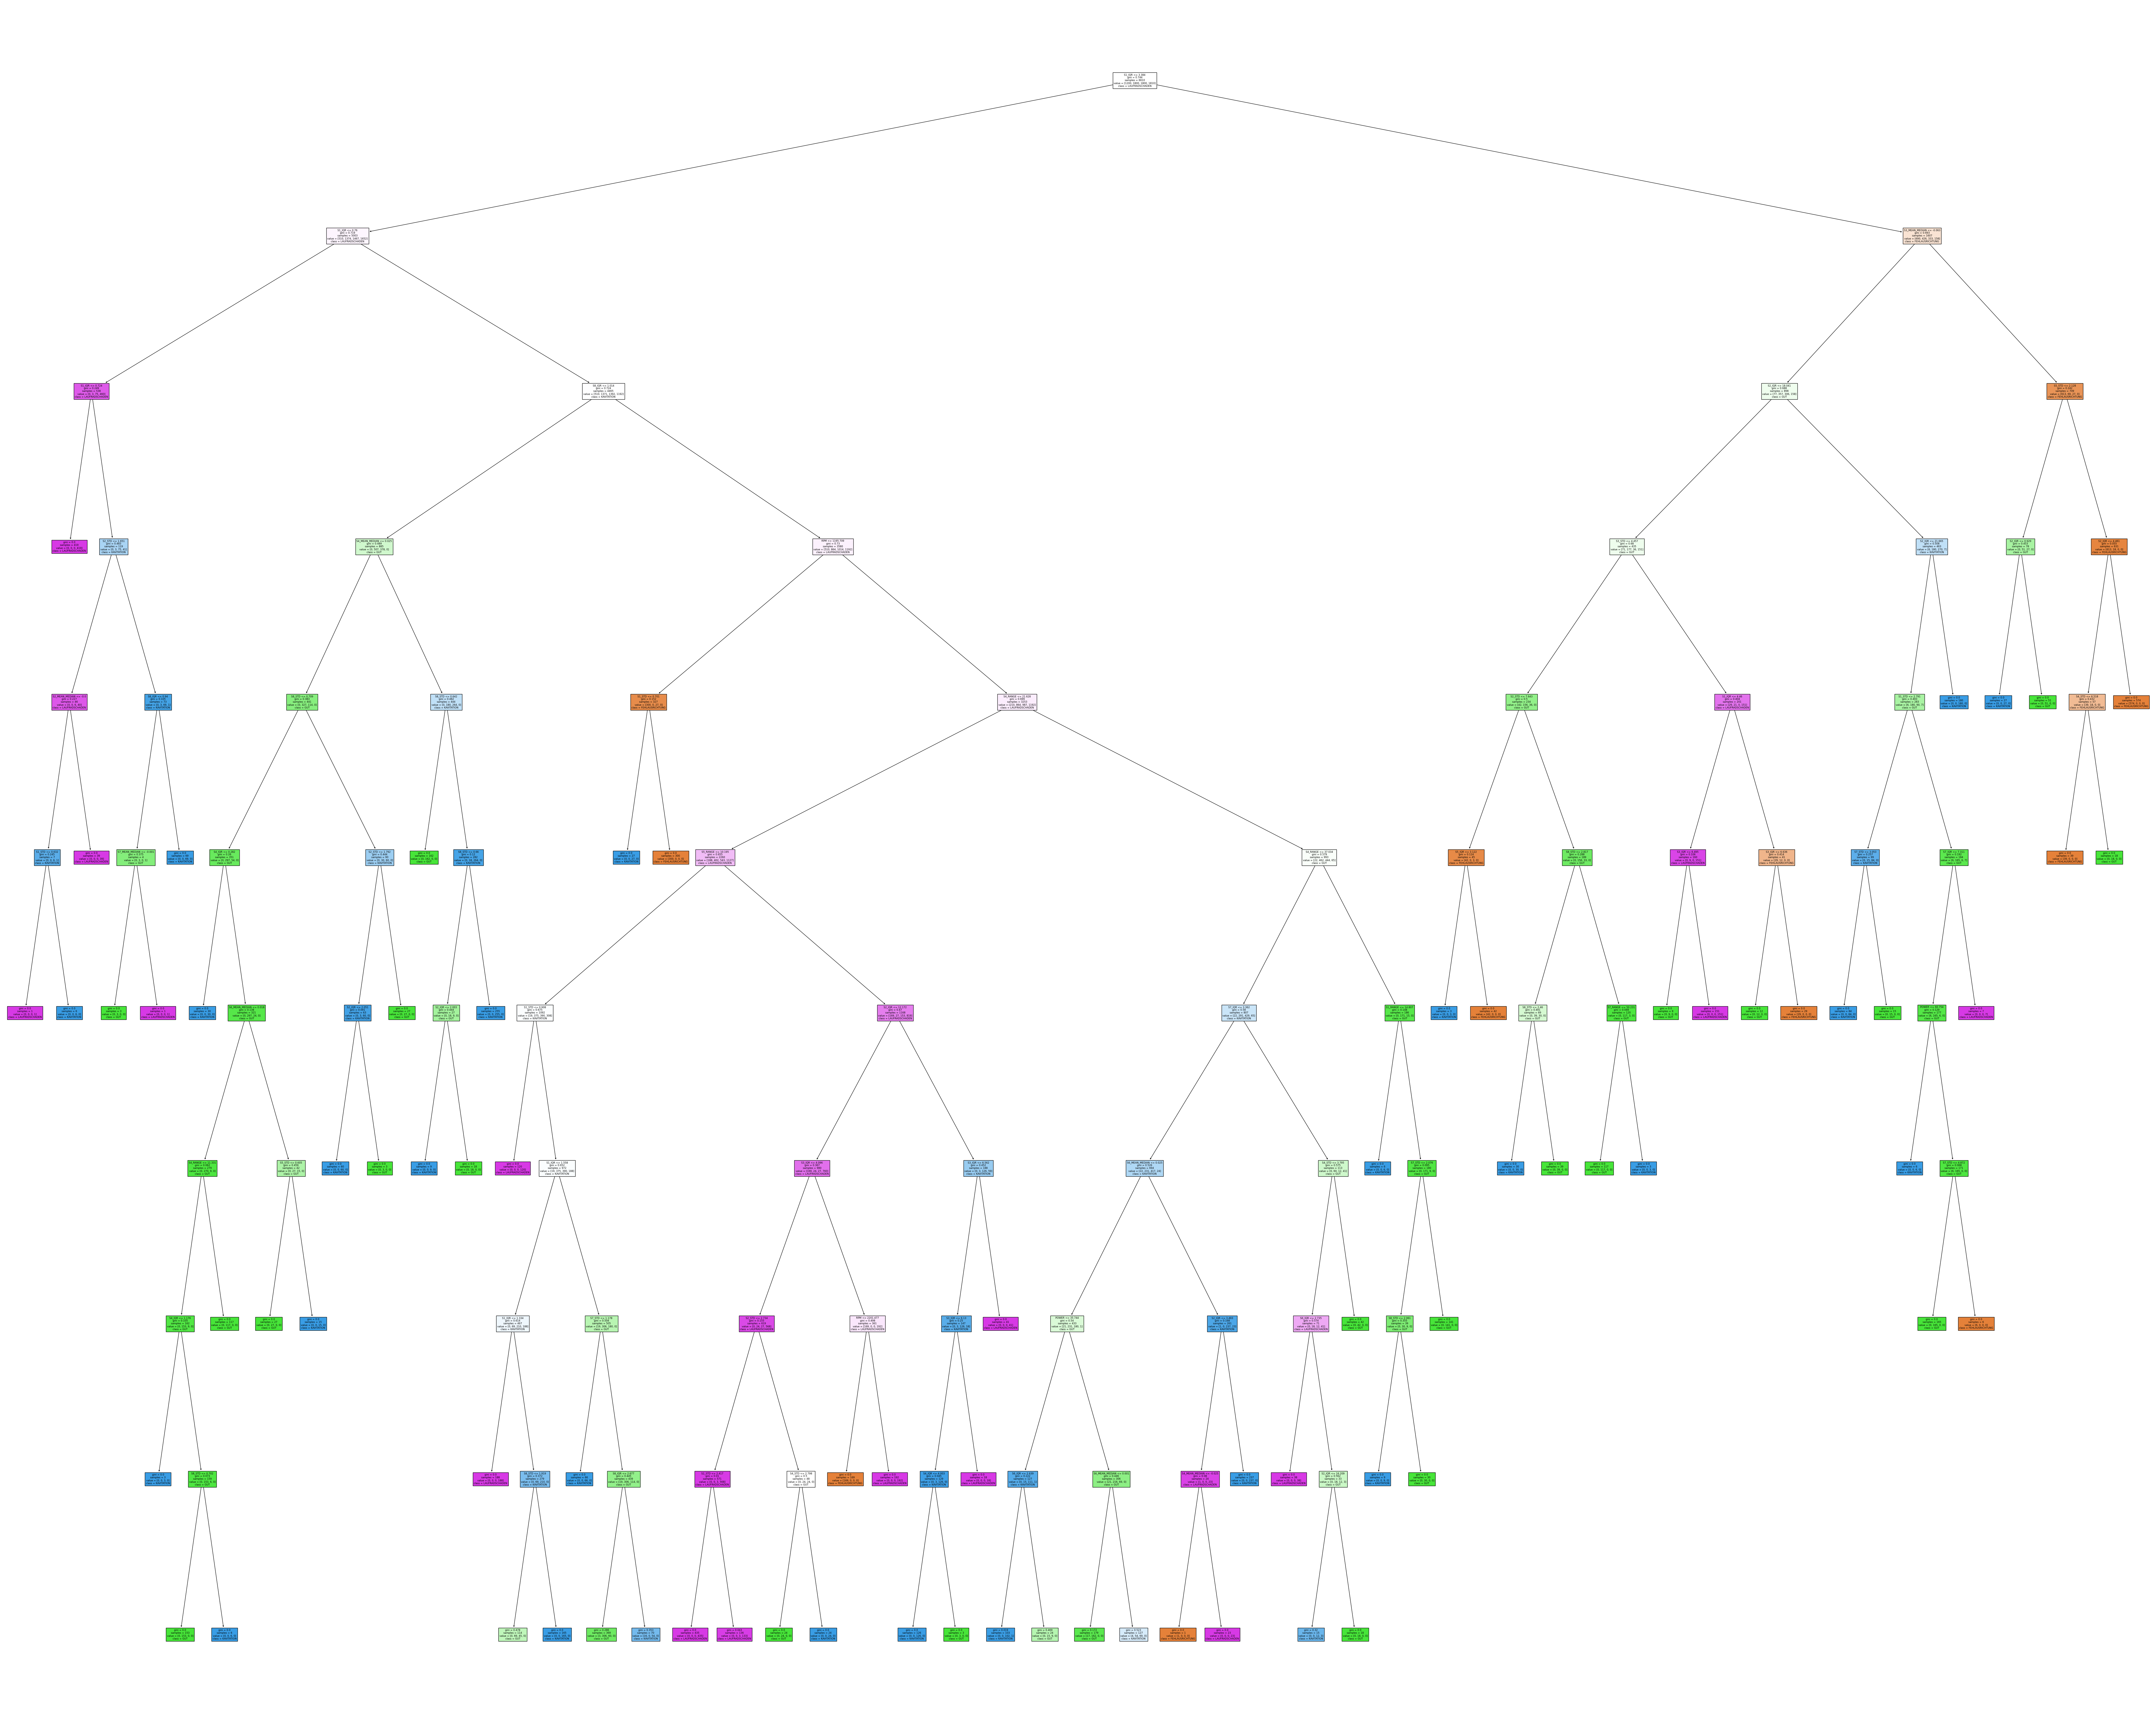

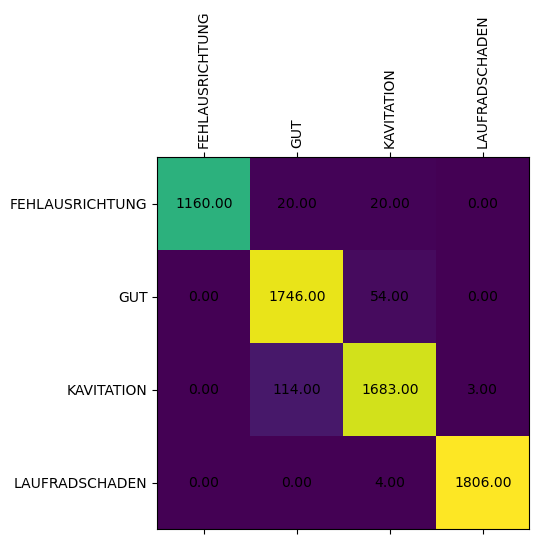

Test Accuracy: 1.000
Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

1.0606 ± 0.0632  RPM
0.8750 ± 0.0293  S1_IQR
0.6169 ± 0.0075  S3_IQR
0.3084 ± 0.0072  S3_MEAN_MEDIAN
0.2492 ± 0.0121  S5_RANGE
0.2162 ± 0.0090  S8_IQR
0.2050 ± 0.0161  S4_RANGE
0.1949 ± 0.0116  S2_STD
0.1852 ± 0.0095  S2_IQR
0.1271 ± 0.0163  S1_STD
0.0774 ± 0.0029  S5_STD
0.0716 ± 0.0057  S8_STD
0.0672 ± 0.0073  S7_IQR
0.0554 ± 0.0058  S3_STD
0.0435 ± 0.0045  S6_MEAN_MEDIAN
0.0354 ± 0.0024  POWER
0.0237 ± 0.0028  S7_STD
0.0202 ± 0.0043  S4_STD
0.0202 ± 0.0010  S5_IQR
0.0192 ± 0.0053  S4_MEAN_MEDIAN
          … 14 more …          


In [221]:
# ANALYZE MODEL
import tensorflow as tf
from tensorflow import math as tfmath
import tensorflow_probability as tfp
import eli5
from eli5.sklearn import PermutationImportance
import joblib
from matplotlib import pyplot
from xgboost import XGBClassifier, plot_tree
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

csvTest = read_csv(PATH_FEATURE_DATA + selectedTestFile, delimiter=";")
testData = csvTest.values
testX, testY = testData[:, 2:].astype('float32'), testData[:, 1:2]
featureNames = csvTest.columns.values[2:].tolist()




model = None
predictions = None
transformedTestY = None
confusionMatrix = None
classes = None
if (selectedModelFile.startswith('dnn')):
    onehotencoder = None
    with open(PATH_MODEL + selectedModelFile + '/encoder.pickle', 'rb') as f:
        onehotencoder = joblib.load(f)
    classes = onehotencoder.categories_[0]
    transformedTestY = onehotencoder.transform(testY).toarray()    

    model = tf.keras.models.load_model(PATH_MODEL + selectedModelFile)
    predictions = model.predict(testX)

    confusionMatrix = tf.math.confusion_matrix(np.argmax(transformedTestY, axis=1), np.argmax(predictions, axis=1))
    equality = tf.math.equal(np.argmax(predictions, axis=1), np.argmax(transformedTestY, axis=1))
    accuracy = tf.math.reduce_mean(tf.cast(equality, tf.float32))
elif (selectedModelFile.startswith('xgb')):
    labelEncoder = None
    with open(PATH_MODEL + selectedModelFile + '/encoder.pickle', 'rb') as f:
        labelEncoder = joblib.load(f)
    classes = labelEncoder.classes_
    transformedTestY = labelEncoder.transform(np.ravel(testY))

    model = XGBClassifier()
    model.load_model(PATH_MODEL + selectedModelFile + '/xgb.model')
    predictions = model.predict(testX)
    confusionMatrix = tfmath.confusion_matrix(transformedTestY, predictions)

    for i in range(model.n_estimators):
        plot_tree(model, num_trees=i, fmap=PATH_MODEL + selectedModelFile + '/feature_map.txt')
        pyplot.gcf().set_dpi(1200)
        pyplot.show()


    #pyplot.show()
    equality = tf.math.equal(predictions, transformedTestY)
    accuracy = tf.math.reduce_mean(tf.cast(equality, tf.float32))
elif (selectedModelFile.startswith('dtc')):
    labelEncoder = None
    with open(PATH_MODEL + selectedModelFile + '/encoder.pickle', 'rb') as f:
        labelEncoder = joblib.load(f)
    classes = labelEncoder.classes_
    transformedTestY = labelEncoder.transform(np.ravel(testY))

    model = joblib.load(PATH_MODEL + selectedModelFile + '/dtc.model')

    predictions = model.predict(testX)
    accuracy = accuracy_score(transformedTestY, predictions)
    confusionMatrix = tfmath.confusion_matrix(transformedTestY, predictions)
    plt.figure(figsize=(100, 80))       
    tree.plot_tree(dt, feature_names=featureNames, class_names=labelEncoder.classes_, filled=True)
    plt.show()

mat = pyplot.matshow(confusionMatrix, 1)
mat.axes.set_xticks(np.arange(0, len(classes), 1))
mat.axes.set_yticks(np.arange(0, len(classes), 1))
mat.axes.set_xticklabels(classes, rotation=90)
mat.axes.set_yticklabels(classes)
for (x, y), value in np.ndenumerate(confusionMatrix):
    pyplot.text(y, x, f"{value:.2f}", va="center", ha="center")
pyplot.show()


print('Test Accuracy: %.3f' % accuracy)


#correlationMatrix = tfp.stats.correlation(testX)
#pyplot.matshow(correlationMatrix)
#pyplot.show()

perm = PermutationImportance(model, scoring="neg_mean_squared_error", random_state=1).fit(testX, transformedTestY)
print(eli5.format_as_text(eli5.explain_weights(perm, feature_names=featureNames)))

## 7. Statische Interpretation des Resultats

- Welches Ergebnis haben wir erzielt und wie kann man es anwenden?
